# <center> Range Look-Up Table for Fitting Any Function </center>
### <center> Tsung-Chu Huang </center>
### <center> 2020/11/9 </center>

## (1) Conventional Look-Up Table

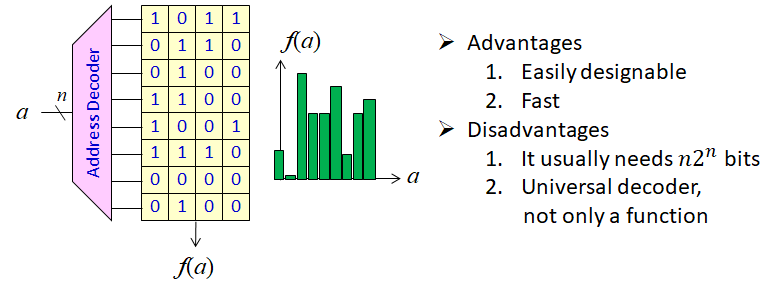

## (2) Range Look-Up Table (RLUT) for Piece-Wise Line (PWL) Functions

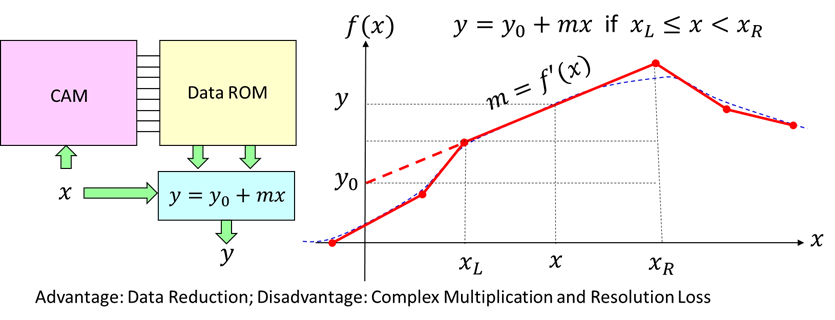

## (3) Motivation:

#### Taking advantage of 2-Power Law:  if m is a light number, $2^(-i)+2^(-j)+2^(-k)$, then $mx = x\ggg i + x\ggg j + x\ggg k$.

## (4) Proposed RLUT Structure


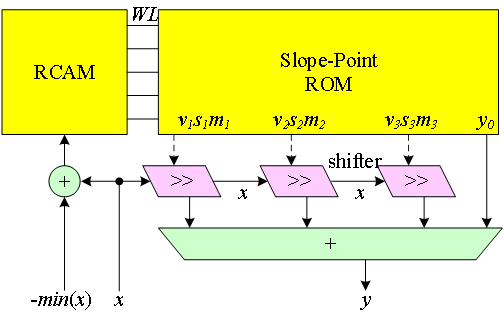

## (5) Fitting Algorithm

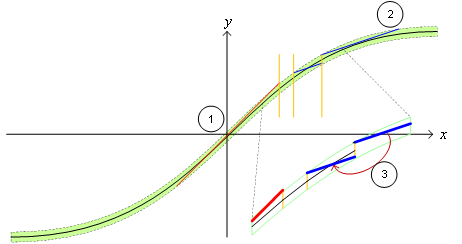

## (6) PERFiT: Perfect Efficient Range-CAM-based Fitting -- A RLUT Optimizer

*** PERFIT: Perfect Efficient Range-CAM-based Fitting ***
#Records=95 12-bit with 8-bit mentissa


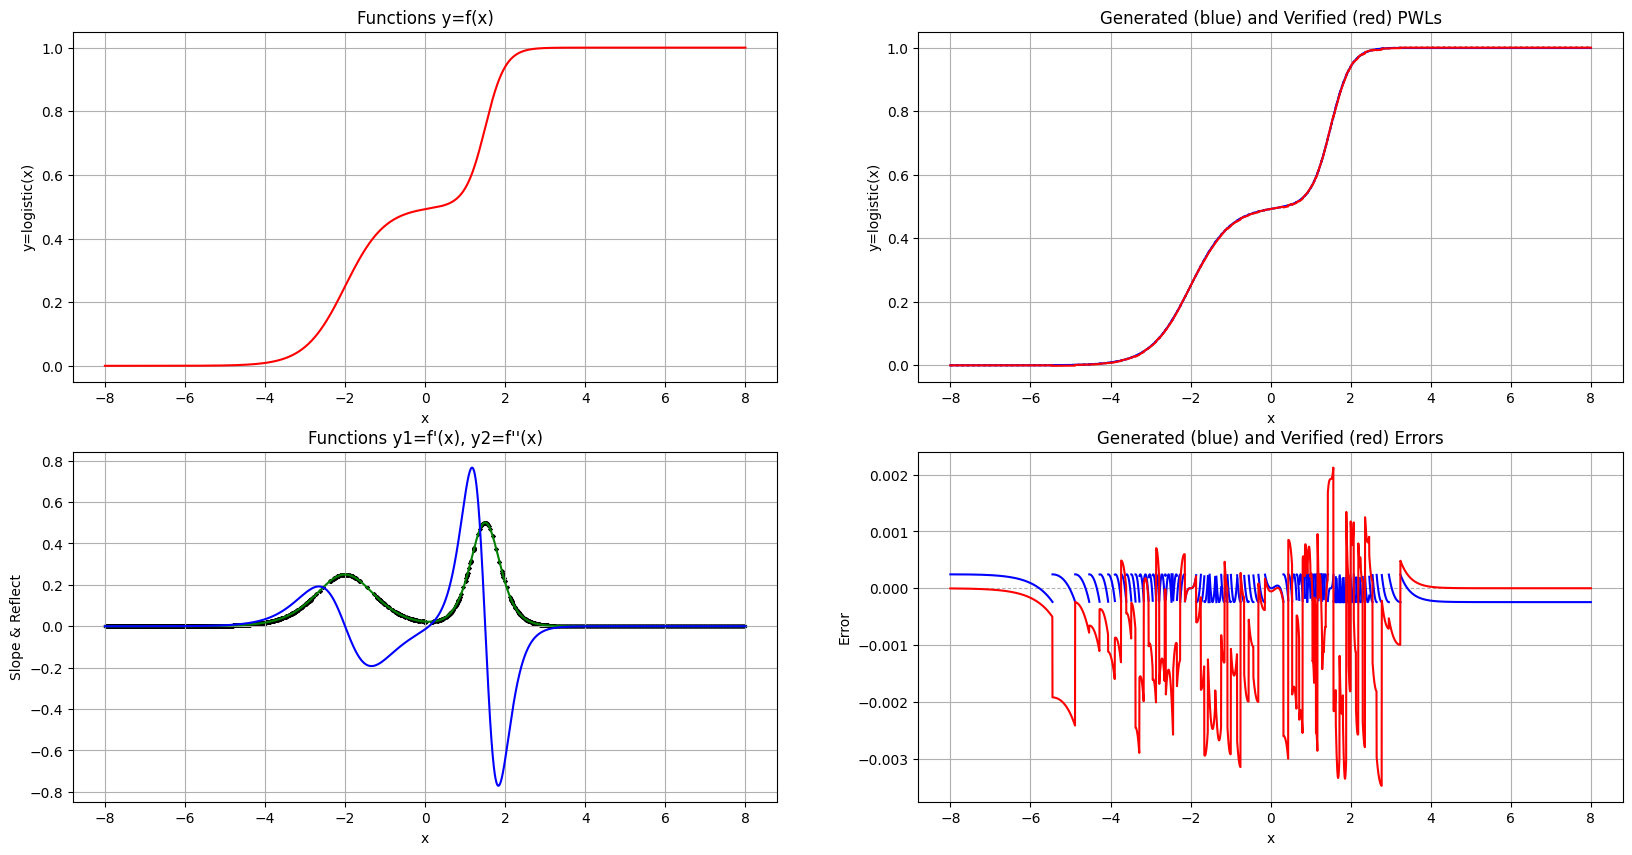

In [2]:
### PERFiT: Perfect Efficient Range-CAM-based Fitting ###
%matplotlib inline
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import math
import os
from TCB import *

####################################
### Design Script
print('*** PERFIT: Perfect Efficient Range-CAM-based Fitting ***')
def logistic(X):
    return (1 + np.tanh(X))/2
def pointfunction(X):
    return (0.5*logistic(X+2)+0.5*logistic(2*X-3))
### Function to Fit
def F(x):
    return (0.5*logistic(x+2)+0.5*logistic(2*x-3))

#######
Nbit = 12 ### nMOS count in a RCAM comparactor
Ni = 4 ### mentissa Nm = Nbit - Ni, including negative floats
Nm = Nbit - Ni  ### eg. <4.8> for x
xMax = (1<< (Ni-1))
xMin = -xMax

# Initial Setting
L, R, e = -1, 1, 1/(1<<Nbit)

###
N = 1 << Nbit
dx = (xMax - xMin)/N
x = np.arange(N+1) * dx + xMin

y = []
yh = []
for i in range(x.size):
    y.append(F(x[i]))
    yh.append(F(x[i]-dx/2))
y = np.array(y)
yh = np.array(yh)

### y1 = slope = dyh/dx
y1 = np.diff(yh) / dx
y1h = np.diff(y) / dx
### y2 = reflection = ddy1h/ddx
y2 = np.diff(y1h) / dx
y1=np.append(y1, y1[y1.size-1])
y1=np.append(y1h, y1h[y1h.size-1])
y2=np.insert(y2, 0, y2[0], 0)
y2=np.append(y2, y2[y2.size-1])

### calculate arithmetic weight of y1
n = Nbit
if max(y1)*min(y1)<0:
    n -= 1
Iy1 = (abs(y1) * (1<<n) + 0.5).astype(int)
W = []
for i in range(Iy1.size):
    W.append(Weight(Iy1[i]))
W = np.array(W)

####################################
f1 = plt.figure(figsize=(20,10))
ax1 = f1.add_subplot(221)
plt.ylabel('y=logistic(x)')
plt.xlabel('x')
plt.title('Functions y=f(x)')
plt.grid(True)
ax1.plot(x, y, 'r')
###
ax2 = f1.add_subplot(222)
ax2.plot(x, y, 'k:')
plt.ylabel('y=logistic(x)')
plt.xlabel('x')
plt.title('Generated (blue) and Verified (red) PWLs')
plt.grid(True)
###
ax3 = f1.add_subplot(223)
plt.ylabel('Slope & Reflect')
plt.xlabel('x')
plt.title('Functions y1=f\'(x), y2=f\'\'(x)')
plt.grid(True)
ax3.plot(x, y1, 'g')
ax3.plot(x, y2, 'b')
###
ax4 = f1.add_subplot(224)
plt.ylabel('Error')
plt.xlabel('x')
plt.title('Generated (blue) and Verified (red) Errors')
plt.grid(True)
ax4.plot(x, x*0, 'w:')        
####################################
Tab = []
###
def PWL(L, R, mL, mR): #return a list of points from L to R with maximum error e
    if L>=R:
        return 0
    # scoping the range with W <= 3
    IxRange = np.intersect1d( np.where(x>=L), np.where(x<=R) )
    Iy1Light = np.intersect1d( np.where(W<=3), IxRange)
   
    if Iy1Light.size > 0:
        # if light y1 exists, searching (L1, R1) from min(abs(y2)), recursively call PWL(L, L1, e) and PWL(R1, R, e), return their concatenation
        Iy2Sort = Iy1Light[np.argsort(abs(y2[Iy1Light]))]
        ###
        ax3.scatter(x[Iy1Light], y1[Iy1Light], s=2, c="black")
        m = y1[Iy2Sort[0]]
        xm = x[Iy2Sort[0]]
        ym = y[Iy2Sort[0]]
        y0 = ym - m * xm
        yL = m * L + y0
        yR = m * R + y0
        #ax2.plot([L, R], [yL, yR], 'gray')
        Err = m * x[IxRange] + y0 - y[IxRange]
        Ierr = np.where(abs(Err) < e )
        if Err[Ierr][0] * Err[Ierr][-1] >= 0 :
            Ierr = np.where(abs(Err) < 2*e )
            if Err[Ierr][0] > 0 or  Err[Ierr][-1] >  0 :
                y0 = y0 - e
                Err[Ierr] = Err[Ierr] - e
            else:
                y0 = y0 + e
                Err[Ierr] = Err[Ierr] + e
    else:
        # else searching from min(abs(y1)), recursively call and return
        if abs(mL)<abs(mR):
            m = mL
            xm = x[IxRange[0]]
            ym = y[IxRange[0]]
        else:
            m = mR
            xm = x[IxRange[-1]]
            ym = y[IxRange[-1]]
        y0 = ym - m * xm
        Err = m * x[IxRange] + y0 - y[IxRange]
        Ierr = np.where(abs(Err) < 2 * e)
        if y2[IxRange[Ierr[0][0]]] > 0:
            y0 = y0 + e
            Err[Ierr] = Err[Ierr] + e
        else:
            y0 = y0 - e
            Err[Ierr] = Err[Ierr] - e 
    xTan = x[IxRange[Ierr]]
    xL = xTan[0]
    xR = xTan[-1]
    ax2.plot([xL, xR], [m*xL+y0,m*xR+y0], "blue")
    ###
    ax4.plot(x[IxRange[Ierr]], Err[Ierr], "blue")
    ###
    Tab.append([xL, xR, m, y0])
    if L<xL:
        mL = PWL(L, xL, mL, m)
    if xR<R:
        mR = PWL(xR, R, m, mR)
    return m
####################################
# Example: <4.8> 4-bit integer, 8-bit mantissa
#       x-x0      m                       y0
# 010010111010 10 0010 11 1000 00 0000 000001110011
# 4.726563      + <<2   - <<8 + 0<<0   0.449219
# y = +x<<2 -x<<8 + 0.449219           if x>4.726563
#
def Tabulate():
    LUT = open("LUT.txt", "w")
    Tab.sort()
    L = len(Tab)
    print("#Records=%d %d-bit with %d-bit mentissa" % (L, Nbit, Nm))
    for i in range(L):
        R = Tab[i]
        N = 1<<(Nm+1)
        xL = int((R[0]-xMin)*N + 0.5)
        xR = int((R[1]-xMin)*N + 0.5)
        m = int(R[2]*(1<<Nbit) + 0.5) ###
        y0 = int(R[3]*N + 0.5)
        mTCB = ("0".zfill(Nbit) + Bin2TCB(m))[-13:-1]
        w = SWeight(mTCB)
        xB = bin(xL)
        y0B = bin(y0)
        line = xB[2:len(xB)-1].zfill(Nbit) + " "
        j = 0
        for i in range(len(mTCB)):
            if mTCB[i] != '0':
                j += 1
                s = bin(i)
                s = s[2:len(s)].zfill(4)
                if mTCB[i] == '+':
                    line += "10 " + s + " "
                else:
                    line += "11 " + s + " "
        while j<3:
            j += 1
            line += "00 0000 "
        line += y0B[2:len(y0B)-1].zfill(Nbit) + "\n"
        LUT.write(line)
    LUT.close()
####################################
def Verify():
    LUT = open("LUT.txt", "r")
    X, A, B, V = [], [], [], []
    while True:
        line = LUT.readline()        
        if len(line)==0:
            LUT.close()
            break
        L = line.split()
        X.append(int(L[0], 2)/(1<<Nm) + xMin)
        M = []
        for i in range(3):
            M.append([int(L[1+i*2], 2), int(L[2+i*2], 2)])
        A.append(M)
        B.append(int(L[7], 2)/(1<<Nm))
    X = np.array(X)
    for i in range(len(x)):
        I = np.where(X<=x[i])
        if X[I].size < 1:
            print("!!!", i, I)
            return
        k = I[0][-1]
        Y = B[k]
        for j in range(3):
            if A[k][j][0] == 2:
                Y += x[i]/(1<<A[k][j][1])
            elif A[k][j][0] ==3:
                Y -= x[i]/(1<<A[k][j][1])
        V.append(Y)
    V = np.array(V)
    E = V - y
    ax2.plot(x, V, 'r')
    ax4.plot(x, E, 'r')
####################################
m = PWL(-8, 8, 0, 0)
###
Tabulate()
Verify()

####################################
plt.savefig("Curves.png",format = 'png', dpi=300)
plt.show()

## (7) RLUT Synthesizer to Verilog for FPGA

In [2]:
### PERFiT: Perfect Efficient Range-CAM-based Fitting ###
### Transfer the LUT generated by PERFiT to Verilog IP

### input files
# fileName=input('Enter the file name: ')
fileName = 'LUT.txt'
infile=open(fileName,'r')
lutList=[line.rstrip().split(' ') for line in infile]
infile.close()

### 
x, v, s, m, y0 =[], [], [], [], []

for i in range(len(lutList)):
    if i != 0:
        x.append(lutList[i][0])
    v.append(lutList[i][1][0]+lutList[i][3][0]+lutList[i][5][0])
    s.append(lutList[i][1][1]+lutList[i][3][1]+lutList[i][5][1])
    m.append(lutList[i][2]+lutList[i][4]+lutList[i][6])
    y0.append(lutList[i][7])
    
xBit=len(x[0])
yBit=len(y0[0])
vBit=len(v[0])
sBit=len(s[0])
mBit=len(m[0])
mBit1=len(lutList[0][2])

########      write file.v      ########

fn = 'RCAM2.v'
outfile=open(fn,'w')

### module, input, output, parameter...
outfile.write('module RCAM(X, Y);\n')
outfile.write('\tinput\t[{0:d}:0]\tX; // fixed-point <4.8> in [-8, 8) \n'.format(xBit-1))
outfile.write('\toutput\t[{0:d}:0]\tY; // fixed-point <4.8> in [-8, 8) \n'.format(yBit-1))
outfile.write('\twire\t[{0:d}:0]\tx;\n'.format(xBit-1))
outfile.write('\tassign x = {~X[%d], X[%d:0]};\n\n' % (xBit-1, xBit-2) )

### LE
outfile.write("\twire [{0:d}:0] LE;\n".format(len(x)-1))
for i in range(len(x)):
    outfile.write("\tassign LE[{0:d}] = (x <= {1:d}'b{2:s});\n".format(i,xBit,x[i]))

### WL
outfile.write('\n\twire [{0:d}:0] WL;\n'.format(len(y0)-1))
for i in range(len(y0)):
    if i == 0:
        outfile.write("\tassign WL[0] = LE[0];\n")
    elif i == len(y0)-1:
        outfile.write("\tassign WL[{0:d}] = !LE[{1:d}];\n".format(i,i-1))
    else:
        outfile.write("\tassign WL[{0:d}] = LE[{0:d}] && (!LE[{1:d}]);\n".format(i,i-1))

### case(WL)
outfile.write("\n\treg [{0:d}:0] v;\n".format(vBit-1))
outfile.write("\treg [{0:d}:0] s;\n".format(sBit-1))
outfile.write("\treg [{0:d}:0] m;\n".format(mBit-1))
outfile.write("\treg [{0:d}:0] y0;\n".format(yBit-1))
outfile.write("\n\talways@*\n")
outfile.write("\tbegin\n")
outfile.write("\t\tcase(WL)\n")

for i in range(len(y0)):
    wl=''
    for j in range(len(y0)-1, -1, -1):
        if j == i:
            wl += '1'
        else:
            wl += '0'
    outfile.write("\t\t\t{0:d}'b{1:s}: {{v, s, m, y0}} = {2:d}'b{3:s};\n".format(
                                    len(y0),wl,vBit+sBit+mBit+yBit,v[i]+s[i]+m[i]+y0[i]))
outfile.write("\t\tendcase\n")
outfile.write("\tend\n\n")

### Y (output)
outfile.write("\tassign Y = y0 + ( v[0] ? (s[0]? ~(x>>m[{0:d}:0])+1 : x>>m[{0:d}:0]) : 0 )\n".format(mBit1-1))
outfile.write("\t\t\t+ ( v[1] ? (s[1]? ~(x>>m[{0:d}:{1:d}])+1 : x>>m[{0:d}:{1:d}]) : 0 )\n".format(mBit1*2-1, mBit1))
outfile.write("\t\t\t+ ( v[2] ? (s[2]? ~(x>>m[{0:d}:{1:d}])+1 : x>>m[{0:d}:{1:d}]) : 0 );\n".format(mBit1*3-1, mBit1*2))

### endmodule
outfile.write("\nendmodule\n")
outfile.close()
print('Verilog file %s is generated.' % fn)

Verilog file RCAM2.v is generated.


## (8) Hardware IP Verification

* Upload Kernel IP Design to Vivado
* Block Design using Vivado HLx 2018.2
* Programming to Pynq-Z1 and Verifying

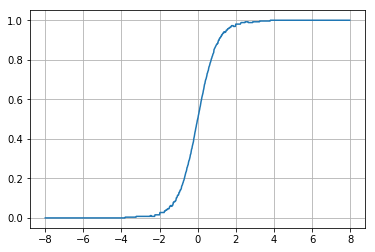

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from pynq import Overlay
from pynq import MMIO
overlay = Overlay('./bitstream/LogisticRLUT.bit')
ip = MMIO(0x43C00000, 0x10000)

x, y = [], []
for i in range(800):
    x.append(i/50 -8)
    ip.write(0, int(x[-1]*256))
    y.append( (ip.read(4))/256 )
    
plt.plot(x, y)
plt.grid(True)   

## (9) Fault Insertion: Several bits are aged after 1 year.

#### To be continued.  $\blacktriangleright$ ECC

* The better candicate is the **AN Codes**.
* $AN = \{C| C = AN,\ N \in \mathbb{Z}\ \wedge\ 0\le N < B \}$
* Example: $N=85=01010101_2$ and select $A=3$, then $AN=+0000000-_{TCB}$
* Refer to https://en.wikipedia.org/wiki/AN_codes